# Building and Mining a Knowledge Graph for ML Research
# Author: João Pereira
# Date: March 8, 2025

In [38]:
# ============================================
# 1. Imports and Setup
# ============================================
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import os
from tqdm import tqdm  # For progress bars

# For NLP
import spacy
import re
from collections import Counter

# For Neo4j
from py2neo import Graph, Node, Relationship

# For evaluation
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Configure display
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Neo4j Connection
NEO4J_URI = "bolt://localhost:7687"  # Update as needed
NEO4J_USER = "neo4j"
NEO4J_PASS = "password123"  # Update as needed

try:
    graph = Graph(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASS))
    print("✅ Connected to Neo4j successfully!")
except Exception as e:
    print(f"❌ Error connecting to Neo4j: {e}")

✅ Connected to Neo4j successfully!


In [57]:
# ============================================
# 2. Data Collection & Integration
# ============================================

# 2.1 Semantic Scholar Dataset Integration
def load_semantic_data(data_path="data/processed/papers_semanticscholar_clean.json", max_papers=250):
    """Loads the pre-cleaned Semantic Scholar data from file and picks top N (since it's sorted by relevance)."""
    if not os.path.exists(data_path):
        print(f"❌ Cleaned Semantic Scholar data not found at {data_path}")
        return []
    print(f"📄 Loading cleaned Semantic Scholar data from {data_path}")
    with open(data_path, "r", encoding="utf-8") as f:
        all_papers = json.load(f)
    # Since your Semantic Scholar file is presumably sorted by relevance (descending citationCount),
    # we just take the top 'max_papers'.
    # If it's NOT sorted, you'd random sample or do .head(250) after sorting.
    if len(all_papers) > max_papers:
        all_papers = all_papers[:max_papers]
    print(f"✅ Using {len(all_papers)} semantic papers from {data_path}")
    return all_papers

# 2.2 ArXiv Dataset Integration
def load_arxiv_data(data_path="data/processed/arxiv_ml_subset_clean.json", max_papers=None):
    if not os.path.exists(data_path):
        print(f"❌ File not found: {data_path}")
        return []

    print(f"📄 Loading ArXiv ML papers dataset from {data_path}")
    arxiv_data = []
    with open(data_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                paper = json.loads(line)
                arxiv_data.append(paper)
            except json.JSONDecodeError as e:
                print(f"❌ JSON decode error in line: {e}")
                continue

    print(f"✅ Loaded {len(arxiv_data)} papers from ArXiv dataset")

    if max_papers is not None and len(arxiv_data) > max_papers:
        arxiv_data = list(pd.DataFrame(arxiv_data).sample(n=max_papers, random_state=42).to_dict(orient="records"))
        print(f"✅ Downsampled ArXiv dataset to {len(arxiv_data)} papers")

    return arxiv_data


# 2.3 Schema Normalization 
def normalize_paper_data(papers, source):
    """Normalize paper data to a common schema."""
    normalized = []
    
    for paper in papers:
        if source == "semanticscholar":
            norm_paper = {
                "paper_id": paper.get("paperId", ""),
                "title": paper.get("title", ""),
                "abstract": paper.get("abstract", ""),
                "year": paper.get("year"),
                "venue": paper.get("venue", ""),  # NEW: Include venue
                "authors": [author.get("name", "") for author in paper.get("authors", [])],
                "citation_count": paper.get("citationCount"),
                "reference_count": paper.get("referenceCount"),
                "source": "semanticscholar",
                "raw_data": paper  # Keep original data for reference
            }
        elif source == "arxiv":
            norm_paper = {
                "paper_id": paper.get("id", ""),
                "title": paper.get("title", ""),
                "abstract": paper.get("abstract", ""),
                "year": int(paper.get("update_date", 0) / 1000 / 60 / 60 / 24 / 365 + 1970) if paper.get("update_date") else None,
                "venue": paper.get("venue", ""),  # NEW: if available; might be empty
                "authors": paper.get("authors", "").split(",") if paper.get("authors") else [],
                "citation_count": None,  # Not available in ArXiv data
                "reference_count": None,  # Not available in ArXiv data
                "categories": paper.get("categories", "").split(),
                "source": "arxiv",
                "raw_data": paper
            }
        normalized.append(norm_paper)
    
    return normalized

# 2.4 Data Reconciliation (NEW)
def reconcile_papers(papers_df):
    """
    Reconcile papers from different sources to avoid duplicates.
    Uses title similarity for matching.
    """
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    
    print("🔄 Reconciling papers from different sources...")
    
    # Check if we have multiple sources
    sources = papers_df["source"].unique()
    if len(sources) <= 1:
        print("✅ Only one source, no reconciliation needed")
        return papers_df
    
    # Get papers from each source
    papers_by_source = {source: papers_df[papers_df["source"] == source] for source in sources}
    
    # Use TF-IDF to compute title similarity
    vectorizer = TfidfVectorizer()
    all_titles = papers_df["title"].tolist()
    title_vectors = vectorizer.fit_transform(all_titles)
    
    # Find potential duplicates
    duplicates = []
    for i, source1 in enumerate(sources[:-1]):
        for source2 in sources[i+1:]:
            df1 = papers_by_source[source1]
            df2 = papers_by_source[source2]
            
            print(f"🔍 Checking for duplicates between {source1} and {source2}...")
            
            # Compute similarity for each pair
            for idx1, row1 in tqdm(df1.iterrows(), total=len(df1), desc=f"{source1}-{source2}"):
                title1 = row1["title"]
                vec1 = vectorizer.transform([title1])
                
                # Compute similarity with all titles from source2
                titles2 = df2["title"].tolist()
                vecs2 = vectorizer.transform(titles2)
                similarities = cosine_similarity(vec1, vecs2).flatten()
                
                # Find potential matches
                matches = [(idx2, sim) for idx2, sim in 
                           zip(df2.index, similarities) if sim > 0.9]
                
                for idx2, sim in matches:
                    duplicates.append((idx1, idx2, sim))
    
    # Keep the first occurrence of each paper
    to_drop = set()
    for idx1, idx2, sim in duplicates:
        # Prefer Semantic Scholar due to more metadata
        if papers_df.loc[idx1, "source"] == "semanticscholar":
            to_drop.add(idx2)
        else:
            to_drop.add(idx1)
    
    print(f"✅ Found {len(duplicates)} potential duplicates, removing {len(to_drop)} papers")
    
    # Create reconciled dataframe
    reconciled_df = papers_df.drop(list(to_drop))
    print(f"✅ After reconciliation: {len(reconciled_df)} papers")
    
    return reconciled_df

In [40]:
# ============================================
# 3. Exploratory Data Analysis
# ============================================

def analyze_dataset(papers_df):
    """Perform EDA on the combined dataset."""
    print("📊 Dataset Overview:")
    print(f"Total papers: {len(papers_df)}")
    
    # Source distribution
    source_counts = papers_df["source"].value_counts()
    print("\n📊 Data Sources:")
    print(source_counts)
    
    # Create a pie chart for source distribution
    plt.figure(figsize=(8, 8))
    plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Papers by Source')
    plt.axis('equal')
    plt.show()
    
    # Year distribution
    year_counts = papers_df["year"].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    year_counts.plot(kind="bar")
    plt.title("Distribution of Papers by Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Papers")
    plt.tight_layout()
    plt.show()
    
    # Missing data analysis
    missing_vals = papers_df.isnull().sum()
    print("\n📊 Missing Values:")
    print(missing_vals)
    
    # Create a heatmap for missing values
    plt.figure(figsize=(10, 6))
    sns.heatmap(papers_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Value Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Abstract length distribution
    papers_df["abstract_length"] = papers_df["abstract"].apply(
        lambda x: len(x.split()) if isinstance(x, str) else 0
    )
    
    plt.figure(figsize=(12, 6))
    sns.histplot(papers_df["abstract_length"], bins=30)
    plt.title("Distribution of Abstract Lengths")
    plt.xlabel("Word Count")
    plt.ylabel("Number of Papers")
    plt.tight_layout()
    plt.show()
    
    # Top authors (if available)
    if "authors" in papers_df.columns:
        # Flatten the list of authors
        all_authors = []
        for authors in papers_df["authors"]:
            if isinstance(authors, list):
                all_authors.extend(authors)
        
        # Count occurrences
        author_counts = Counter(all_authors)
        top_authors = pd.DataFrame({
            "author": [author for author, _ in author_counts.most_common(10)],
            "paper_count": [count for _, count in author_counts.most_common(10)]
        })
        
        print("\n📊 Top Authors:")
        print(top_authors)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x="paper_count", y="author", data=top_authors)
        plt.title("Top 10 Authors by Paper Count")
        plt.xlabel("Number of Papers")
        plt.ylabel("Author")
        plt.tight_layout()
        plt.show()
    
    # Sample abstracts
    print("\n📝 Sample Abstracts:")
    for i, row in papers_df.sample(3).iterrows():
        print(f"Title: {row['title']}")
        print(f"Source: {row['source']}")
        abstract_text = row['abstract'] if row['abstract'] is not None else "[No abstract provided]"
        print(f"Abstract: {abstract_text[:300]}...")
        print("-" * 80)

    
    return year_counts

In [41]:
# ============================================
# 4. Enhanced Dataset Extraction
# ============================================

# 4.1 Known Datasets List (Extended)
KNOWN_DATASETS = [
    # Image datasets
    "ImageNet", "CIFAR-10", "CIFAR-100", "MNIST", "Fashion-MNIST",
    "COCO", "Pascal VOC", "Cityscapes", "SVHN", "STL-10",
    
    # NLP datasets
    "GLUE", "SuperGLUE", "SQuAD", "CoNLL", "Penn Treebank",
    "WikiText", "BookCorpus", "IMDB", "SST", "AG News",
    
    # Other ML datasets
    "UCI", "Kaggle", "KITTI", "MovieLens", "Criteo", "Iris",
    "Boston Housing", "Adult", "Wine", "MIMIC"
]

# 4.2 Pattern Matching Extraction
def extract_datasets_simple(text, dataset_list=None):
    """Extract datasets using simple pattern matching."""
    if not text or not isinstance(text, str):
        return []
    
    if dataset_list is None:
        dataset_list = KNOWN_DATASETS
    
    found = []
    text_lower = text.lower()
    
    for ds in dataset_list:
        if ds.lower() in text_lower:
            # Simple context check (can be enhanced)
            context = re.search(r'[^.]*\b' + re.escape(ds.lower()) + r'\b[^.]*\.', text_lower)
            if context:
                found.append((ds, context.group(0), 0.8))  # Dataset, context, confidence
    
    return found

# 4.3 NLP-based Extraction (NEW)
def extract_datasets_nlp(text, nlp_model):
    """Extract datasets using NLP techniques."""
    if not text or not isinstance(text, str):
        return []
    
    found = []
    doc = nlp_model(text)
    
    # Look for entities that might be datasets
    for ent in doc.ents:
        if ent.label_ in ["ORG", "PRODUCT", "WORK_OF_ART"]:
            # Check against known datasets
            matches = [ds for ds in KNOWN_DATASETS if ds.lower() == ent.text.lower()]
            if matches:
                found.append((matches[0], ent.sent.text, 0.9))  # Known dataset with NER match
            elif any(term in ent.text.lower() for term in ["dataset", "corpus", "benchmark"]):
                found.append((ent.text, ent.sent.text, 0.7))  # Likely dataset
    
    # Rule-based extraction for datasets mentioned with specific patterns
    dataset_patterns = [
        r'(?:use|using|used|trained on|evaluate on|tested on)\s+(?:the\s+)?([A-Z][A-Za-z0-9\-]+)(?:\s+dataset)?',
        r'(?:the\s+)?([A-Z][A-Za-z0-9\-]+)(?:\s+dataset|corpus|benchmark)'
    ]
    
    for pattern in dataset_patterns:
        matches = re.finditer(pattern, text)
        for match in matches:
            candidate = match.group(1)
            # Check if candidate is a known dataset or looks like one
            if candidate in KNOWN_DATASETS:
                context = text[max(0, match.start() - 50):min(len(text), match.end() + 50)]
                found.append((candidate, context, 0.85))
    
    return found

# 4.4 Combined Extraction Pipeline
def extract_datasets(papers_df, confidence_threshold=0.7):
    """Extract datasets from paper abstracts using multiple techniques."""
    all_extractions = []
    
    for i, paper in tqdm(papers_df.iterrows(), total=len(papers_df), desc="Extracting datasets"):
        paper_id = paper["paper_id"]
        abstract = paper["abstract"]
        
        if not isinstance(abstract, str) or len(abstract) < 10:
            continue
        
        # Apply both extraction methods
        simple_matches = extract_datasets_simple(abstract)
        nlp_matches = extract_datasets_nlp(abstract, nlp)
        
        # Combine and deduplicate results
        all_matches = {}
        for ds, context, conf in simple_matches + nlp_matches:
            if ds in all_matches:
                # Keep the higher confidence match
                if conf > all_matches[ds][1]:
                    all_matches[ds] = (context, conf)
            else:
                all_matches[ds] = (context, conf)
        
        # Filter by confidence threshold
        for ds, (context, conf) in all_matches.items():
            if conf >= confidence_threshold:
                all_extractions.append({
                    "paper_id": paper_id,
                    "title": paper["title"],
                    "dataset": ds,
                    "context": context,
                    "confidence": conf,
                    "source": paper["source"],
                    "year": paper["year"]
                })
    
    extractions_df = pd.DataFrame(all_extractions)
    print(f"✅ Extracted {len(extractions_df)} dataset mentions from {papers_df['paper_id'].nunique()} papers")
    
    # Analyze extraction results
    if len(extractions_df) > 0:
        # Show top datasets
        top_datasets = extractions_df["dataset"].value_counts().head(10)
        print("\n📊 Top Extracted Datasets:")
        print(top_datasets)
        
        plt.figure(figsize=(12, 6))
        top_datasets.plot(kind="bar")
        plt.title("Top 10 Datasets Mentioned in Papers")
        plt.xlabel("Dataset")
        plt.ylabel("Mention Count")
        plt.tight_layout()
        plt.show()
        
        # Show extraction confidence distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(extractions_df["confidence"], bins=10)
        plt.title("Distribution of Extraction Confidence Scores")
        plt.xlabel("Confidence Score")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()
    
    return extractions_df

In [42]:
# ============================================
# 5. Knowledge Graph Construction
# ============================================

def build_knowledge_graph(papers_df, extractions_df, graph, clear_existing=False):
    """Build the Neo4j knowledge graph.
    
    Parameters:
      clear_existing (bool): If True, deletes all nodes in the database before building the KG.
    """
    print("🔄 Building Knowledge Graph...")
    
    # Optional: Clear existing data if requested
    if clear_existing:
        print("🧹 Clearing existing data in Neo4j...")
        graph.run("MATCH (n) DETACH DELETE n")
    
    # Create indexes for performance using try/except to handle errors
    try:
        graph.run("CREATE INDEX paper_id_index FOR (p:Paper) ON (p.paper_id)")
    except Exception as e:
        print("Index creation error for Paper(paper_id):", e)
        
    try:
        graph.run("CREATE INDEX dataset_name_index FOR (d:Dataset) ON (d.name)")
    except Exception as e:
        print("Index creation error for Dataset(name):", e)
        
    try:
        graph.run("CREATE INDEX source_name_index FOR (s:Source) ON (s.name)")
    except Exception as e:
        print("Index creation error for Source(name):", e)
        
    try:
        graph.run("CREATE INDEX year_value_index FOR (y:Year) ON (y.value)")
    except Exception as e:
        print("Index creation error for Year(value):", e)
        
    try:
        graph.run("CREATE INDEX author_name_index FOR (a:Author) ON (a.name)")
    except Exception as e:
        print("Index creation error for Author(name):", e)
    
    # Create nodes for papers and datasets
    paper_count = 0
    dataset_count = 0
    author_count = 0
    rel_count = 0
    
    # 1. Create Source nodes
    sources = papers_df["source"].unique()
    for source in sources:
        source_node = Node("Source", name=source)
        graph.merge(source_node, "Source", "name")
    
    # 2. Create Year nodes
    years = [y for y in papers_df["year"].unique() if pd.notna(y)]
    for year in years:
        year_node = Node("Year", value=int(year))
        graph.merge(year_node, "Year", "value")
    
    # 3. Process papers and dataset relationships
    for i, paper in tqdm(papers_df.iterrows(), total=len(papers_df), desc="Creating paper nodes"):
        paper_id = paper["paper_id"]
        title = paper["title"]
        source = paper["source"]
        year = paper["year"]
        
        # Skip papers without ID
        if not paper_id:
            continue
        
        # Create Paper node
        paper_node = Node("Paper", 
                          paper_id=paper_id,
                          title=title,
                          abstract=paper["abstract"] if isinstance(paper["abstract"], str) else "")
        graph.merge(paper_node, "Paper", "paper_id")
        paper_count += 1
        
        # Connect to Source
        source_node = graph.nodes.match("Source", name=source).first()
        if source_node:
            rel = Relationship(paper_node, "PUBLISHED_IN", source_node)
            graph.merge(rel)
        
        # Connect to Year if available
        if pd.notna(year):
            year_node = graph.nodes.match("Year", value=int(year)).first()
            if year_node:
                rel = Relationship(paper_node, "PUBLISHED_YEAR", year_node)
                graph.merge(rel)
        
        # Connect to Authors if available
        if isinstance(paper.get("authors"), list):
            for author_name in paper["authors"]:
                if author_name and isinstance(author_name, str):
                    author_node = Node("Author", name=author_name)
                    graph.merge(author_node, "Author", "name")
                    author_count += 1
                    rel = Relationship(author_node, "AUTHORED", paper_node)
                    graph.merge(rel)
    
    # 4. Create Dataset nodes and relationships
    for i, row in tqdm(extractions_df.iterrows(), total=len(extractions_df), desc="Creating dataset relationships"):
        paper_id = row["paper_id"]
        dataset_name = row["dataset"]
        confidence = row["confidence"]
        
        paper_node = graph.nodes.match("Paper", paper_id=paper_id).first()
        if not paper_node:
            continue
        
        # Create Dataset node
        dataset_node = Node("Dataset", name=dataset_name)
        graph.merge(dataset_node, "Dataset", "name")
        dataset_count += 1
        
        # Create relationship with confidence property
        rel = Relationship(paper_node, "USES_DATASET", dataset_node, confidence=confidence)
        graph.merge(rel)
        rel_count += 1
    
    print(f"✅ Knowledge Graph Built: {paper_count} papers, {dataset_count} datasets, {author_count} authors, {rel_count} relationships")
    
    # 5. Summary queries
    print("\n📊 Knowledge Graph Summary:")
    paper_count_query = "MATCH (p:Paper) RETURN count(p) as paper_count"
    dataset_count_query = "MATCH (d:Dataset) RETURN count(d) as dataset_count"
    author_count_query = "MATCH (a:Author) RETURN count(a) as author_count"
    rel_count_query = "MATCH (:Paper)-[r:USES_DATASET]->(:Dataset) RETURN count(r) as rel_count"
    
    print(f"Papers: {graph.run(paper_count_query).data()[0]['paper_count']}")
    print(f"Datasets: {graph.run(dataset_count_query).data()[0]['dataset_count']}")
    print(f"Authors: {graph.run(author_count_query).data()[0]['author_count']}")
    print(f"USES_DATASET Relationships: {graph.run(rel_count_query).data()[0]['rel_count']}")
    
    return paper_count, dataset_count, rel_count


In [ ]:
# ============================================
# 6. Advanced Queries & Analysis 
# ============================================

import sys
sys.path.append("../scripts")  # Adjust path if necessary

from advanced_queries import run_advanced_queries

# Assume 'graph' is already defined and connected
advanced_results = run_advanced_queries(graph)


📊 Top 10 Datasets Overall:
Empty DataFrame
Columns: []
Index: []

📊 Top Dataset Usage by Source:

📊 Dataset Usage Trends Over Time:

📊 Dataset Co-occurrence Analysis:
Empty DataFrame
Columns: []
Index: []

📊 Top Authors Using Popular Datasets:
Empty DataFrame
Columns: []
Index: []


ClientError: [Statement.SyntaxError] The property existence syntax `... exists(variable.property)` is no longer supported. Please use `variable.property IS NOT NULL` instead. (line 3, column 43 (offset: 89))
"    WHERE d.name IN $top_datasets AND exists(p.venue) AND p.venue <> """
                                       ^

In [44]:
# ============================================
# 7. Evaluation Framework
# ============================================

def evaluate_kg(papers_df, extractions_df, graph):
    """Evaluate the quality of the knowledge graph and extractions."""
    print("📏 Evaluating Knowledge Graph Quality...")
    
    # 1. Coverage Metrics
    papers_with_datasets = extractions_df["paper_id"].nunique()
    total_papers = papers_df["paper_id"].nunique()
    coverage = (papers_with_datasets / total_papers) * 100 if total_papers > 0 else 0
    
    print(f"\n📊 Dataset Extraction Coverage:")
    print(f"Papers with extracted datasets: {papers_with_datasets} / {total_papers} ({coverage:.2f}%)")
    
    # 2. Confidence Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(extractions_df["confidence"], bins=20, kde=True)
    plt.axvline(x=0.8, color='red', linestyle='--', label='High Confidence Threshold (0.8)')
    plt.title("Distribution of Dataset Extraction Confidence Scores")
    plt.xlabel("Confidence Score")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 3. Source Comparison
    if "source" in extractions_df.columns:
        extraction_by_source = extractions_df.groupby("source")["paper_id"].nunique()
        papers_by_source = papers_df.groupby("source")["paper_id"].nunique()
        
        source_coverage = pd.DataFrame({
            "papers_with_datasets": extraction_by_source,
            "total_papers": papers_by_source
        }).fillna(0)
        
        source_coverage["coverage_pct"] = (source_coverage["papers_with_datasets"] / 
                                         source_coverage["total_papers"] * 100)
        
        print("\n📊 Dataset Extraction by Source:")
        print(source_coverage)
        
        plt.figure(figsize=(10, 6))
        source_coverage["coverage_pct"].plot(kind="bar")
        plt.title("Dataset Extraction Coverage by Source")
        plt.xlabel("Source")
        plt.ylabel("Coverage (%)")
        plt.tight_layout()
        plt.show()
    
    # 4. Manual Validation Sample
    sample_size = min(10, len(extractions_df))
    validation_sample = extractions_df.sample(sample_size)
    
    print("\n📋 Manual Validation Sample:")
    for i, row in validation_sample.iterrows():
        print(f"Paper: {row['title']}")
        print(f"Extracted Dataset: {row['dataset']} (Confidence: {row['confidence']:.2f})")
        print(f"Context: \"{row['context']}\"")
        print("-" * 80)
    
    # 5. Knowledge Graph Connectivity Analysis
    query_connectivity = """
    MATCH (n)
    WITH labels(n)[0] AS label, count(n) AS node_count
    RETURN label, node_count
    ORDER BY node_count DESC
    """
    node_counts = graph.run(query_connectivity).data()
    
    query_relationships = """
    MATCH ()-[r]->()
    WITH type(r) AS rel_type, count(r) AS rel_count
    RETURN rel_type, rel_count
    ORDER BY rel_count DESC
    """
    rel_counts = graph.run(query_relationships).data()
    
    print("\n📊 Knowledge Graph Structure:")
    print("Node Types:")
    for item in node_counts:
        print(f"  - {item['label']}: {item['node_count']}")
    
    print("\nRelationship Types:")
    for item in rel_counts:
        print(f"  - {item['rel_type']}: {item['rel_count']}")
    
    # 6. Evaluation Summary
    evaluation_summary = {
        "overall_coverage": coverage,
        "node_counts": {item["label"]: item["node_count"] for item in node_counts},
        "relationship_counts": {item["rel_type"]: item["rel_count"] for item in rel_counts},
        "avg_confidence": extractions_df["confidence"].mean()
    }
    
    return evaluation_summary

In [45]:
# ============================================
# 8. Visualization & Reporting
# ============================================

def create_visualization_dashboard(papers_df, extractions_df, analysis_results):
    """Create a comprehensive dashboard of visualizations."""
    print("📊 Creating Visualization Dashboard...")
    
    # Prepare the dashboard with multiple plots
    fig = plt.figure(figsize=(20, 24))
    
    # 1. Papers by Year
    ax1 = fig.add_subplot(421)
    year_counts = papers_df["year"].value_counts().sort_index()
    year_counts.plot(kind="bar", ax=ax1)
    ax1.set_title("Papers by Year")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Number of Papers")
    
    # 2. Papers by Source
    ax2 = fig.add_subplot(422)
    source_counts = papers_df["source"].value_counts()
    source_counts.plot(kind="pie", ax=ax2, autopct='%1.1f%%')
    ax2.set_title("Papers by Source")
    ax2.set_ylabel("")
    
    # 3. Top Datasets
    if len(analysis_results) >= 1 and not analysis_results[0].empty:
        df_top = analysis_results[0]
        ax3 = fig.add_subplot(423)
        sns.barplot(y="dataset", x="usage_count", data=df_top.sort_values("usage_count"), ax=ax3)
        ax3.set_title("Top Datasets by Usage Count")
        ax3.set_xlabel("Number of Papers")
        ax3.set_ylabel("Dataset")
    
    # 4. Dataset Trends Over Time
    if len(analysis_results) >= 2 and not analysis_results[1].empty:
        df_trend = analysis_results[1]
        ax4 = fig.add_subplot(424)
        pivot_trend = df_trend.pivot(index="year", columns="dataset", values="count").fillna(0)
        for col in pivot_trend.columns:
            ax4.plot(pivot_trend.index, pivot_trend[col], marker='o', label=col)
        ax4.set_title("Dataset Usage Trends")
        ax4.set_xlabel("Year")
        ax4.set_ylabel("Number of Papers")
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    # 5. Dataset Confidence Distribution
    ax5 = fig.add_subplot(425)
    sns.histplot(extractions_df["confidence"], bins=20, kde=True, ax=ax5)
    ax5.axvline(x=0.8, color='red', linestyle='--', label='Threshold')
    ax5.set_title("Extraction Confidence Distribution")
    ax5.set_xlabel("Confidence Score")
    ax5.set_ylabel("Count")
    ax5.legend()
    
    # 6. Abstract Length Distribution
    ax6 = fig.add_subplot(426)
    papers_df["abstract_length"] = papers_df["abstract"].apply(
        lambda x: len(x.split()) if isinstance(x, str) else 0
    )
    sns.histplot(papers_df["abstract_length"], bins=30, ax=ax6)
    ax6.set_title("Abstract Length Distribution")
    ax6.set_xlabel("Word Count")
    ax6.set_ylabel("Number of Papers")
    
    # 7. Dataset Extraction Coverage by Source
    ax7 = fig.add_subplot(427)
    extraction_by_source = extractions_df.groupby("source")["paper_id"].nunique()
    papers_by_source = papers_df.groupby("source")["paper_id"].nunique()
    source_coverage = pd.DataFrame({
        "papers_with_datasets": extraction_by_source,
        "total_papers": papers_by_source
    }).fillna(0)
    source_coverage["coverage_pct"] = (source_coverage["papers_with_datasets"] / 
                                     source_coverage["total_papers"] * 100)
    source_coverage["coverage_pct"].plot(kind="bar", ax=ax7)
    ax7.set_title("Dataset Extraction Coverage by Source")
    ax7.set_xlabel("Source")
    ax7.set_ylabel("Coverage (%)")
    
    # 8. Dataset Co-occurrence Heatmap
    if len(analysis_results) >= 3 and not analysis_results[2].empty and len(analysis_results[2]) > 5:
        ax8 = fig.add_subplot(428)
        df_cooccurrence = analysis_results[2]
        
        # Create a square matrix of co-occurrences
        unique_datasets = list(set(df_cooccurrence["dataset1"].tolist() + df_cooccurrence["dataset2"].tolist()))
        comatrix = pd.DataFrame(0, index=unique_datasets, columns=unique_datasets)
        
        for _, row in df_cooccurrence.iterrows():
            d1, d2, count = row["dataset1"], row["dataset2"], row["co_occurrence"]
            comatrix.loc[d1, d2] = count
            comatrix.loc[d2, d1] = count  # Symmetric
        
        # Generate the heatmap
        sns.heatmap(comatrix, annot=True, cmap="YlGnBu", ax=ax8, cbar=True)
        ax8.set_title("Dataset Co-occurrence Matrix")
    
    plt.tight_layout()
    plt.savefig("ml_research_dashboard.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    print("✅ Dashboard created and saved as 'ml_research_dashboard.png'")
    
    # Generate a summary report
    print("\n📝 SUMMARY REPORT:")
    print("=" * 80)
    print(f"Total Papers Analyzed: {len(papers_df)}")
    print(f"Papers with Dataset Mentions: {extractions_df['paper_id'].nunique()} ({extractions_df['paper_id'].nunique()/len(papers_df)*100:.1f}%)")
    print(f"Unique Datasets Identified: {extractions_df['dataset'].nunique()}")
    
    if len(analysis_results) >= 1 and not analysis_results[0].empty:
        print("\nTop 5 Most Used Datasets:")
        for i, row in analysis_results[0].head(5).iterrows():
            print(f"  {row['dataset']}: {row['usage_count']} papers")
    
    print("=" * 80)
    
    return "ml_research_dashboard.png"

🚀 Starting ML Research Dataset Knowledge Graph Analysis

⚡ Running in query-only mode. Skipping data processing and KG construction.

📈 Advanced Queries & Analysis

📊 Top 10 Datasets Overall:
         dataset  usage_count
0          MNIST           13
1       ImageNet            8
2          MIMIC            5
3       CIFAR-10            5
4            UCI            3
5      CIFAR-100            2
6           COCO            2
7        Dataset            2
8  Penn Treebank            1
9           GLUE            1


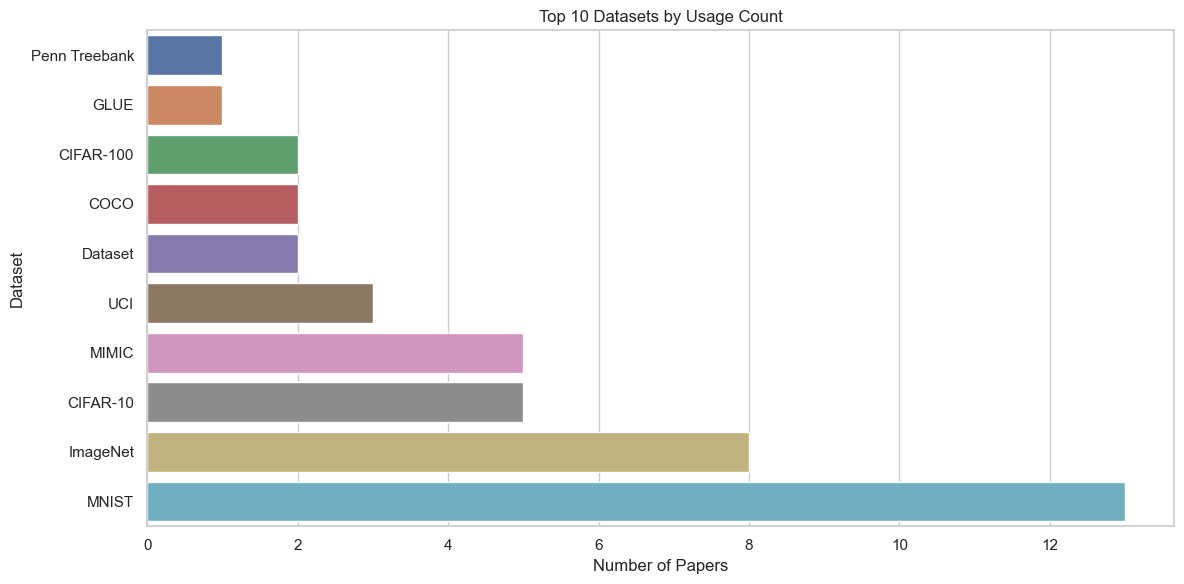


📊 Top Dataset Usage by Source:
source    arxiv  semanticscholar
dataset                         
CIFAR-10    2.0              3.0
ImageNet    4.0              4.0
MIMIC       3.0              2.0
MNIST       3.0             10.0
UCI         0.0              3.0


<Figure size 1200x600 with 0 Axes>

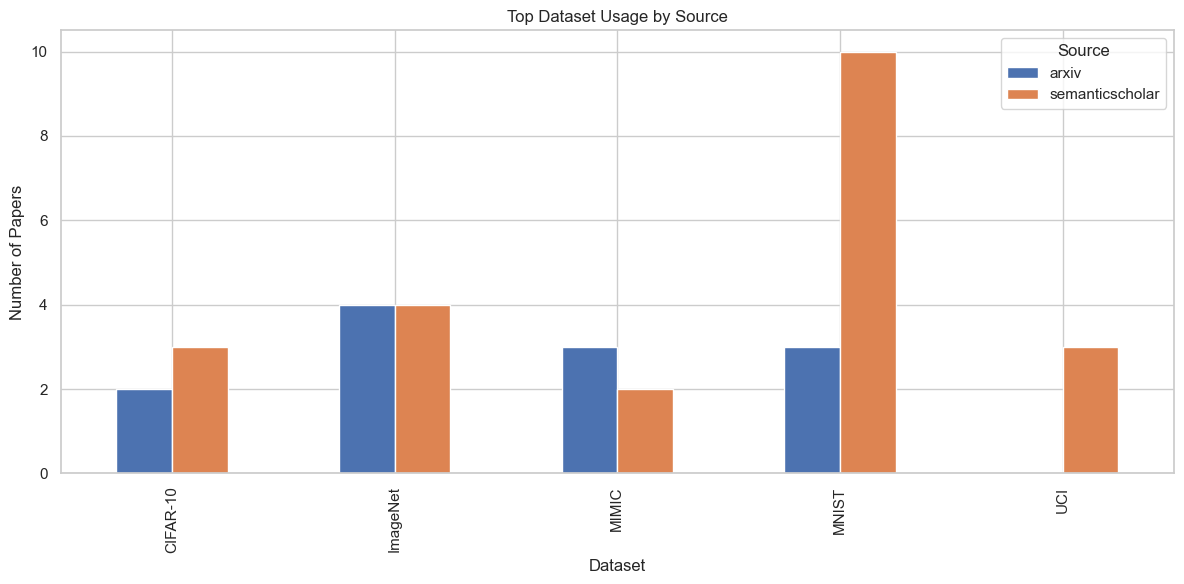


📊 Dataset Usage Trends Over Time:
dataset  CIFAR-10  ImageNet  MIMIC  MNIST  UCI
year                                          
2004          0.0       0.0    0.0    0.0  1.0
2009          1.0       0.0    0.0    1.0  0.0
2012          1.0       1.0    0.0    3.0  1.0
2014          0.0       0.0    0.0    1.0  0.0
2015          0.0       0.0    0.0    1.0  0.0
2016          0.0       3.0    1.0    1.0  0.0
2017          0.0       0.0    1.0    2.0  1.0
2018          1.0       0.0    0.0    1.0  0.0
2019          1.0       3.0    0.0    1.0  0.0
2020          0.0       0.0    1.0    1.0  0.0
2021          0.0       0.0    1.0    0.0  0.0
2022          1.0       0.0    0.0    0.0  0.0
2023          0.0       1.0    0.0    0.0  0.0
2024          0.0       0.0    1.0    1.0  0.0


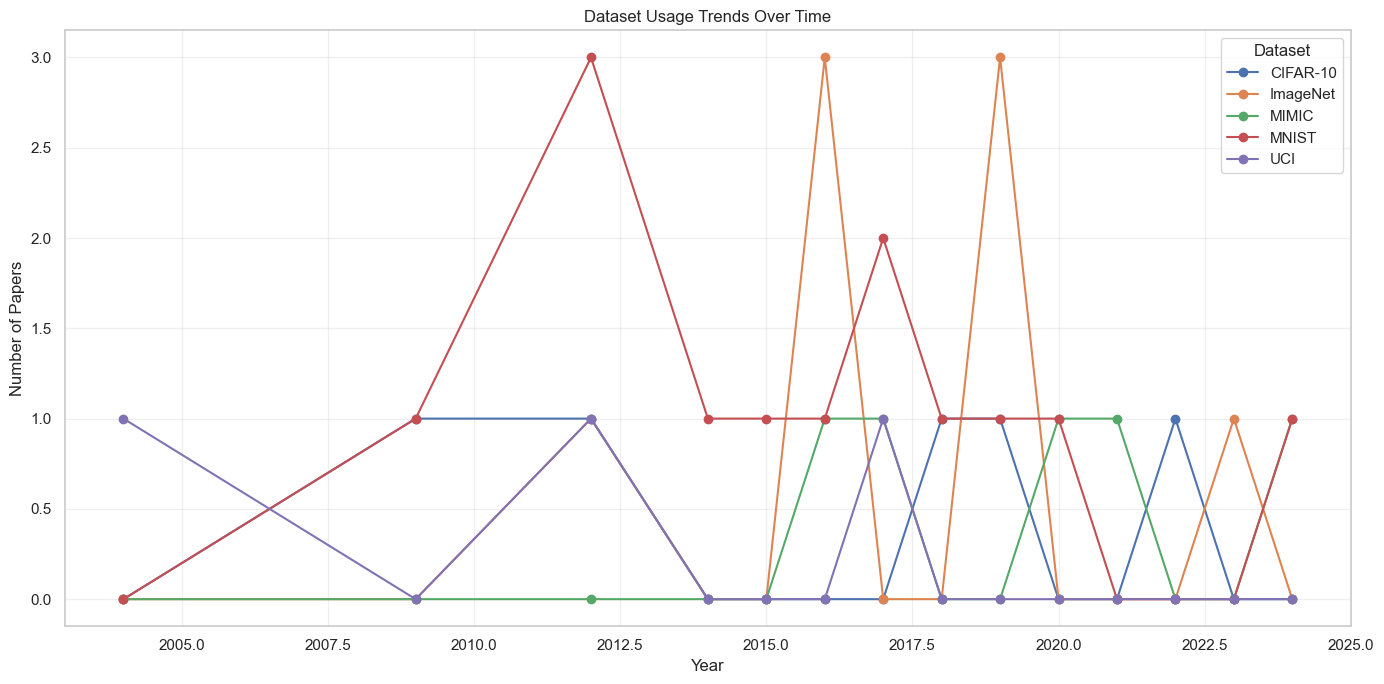


📊 Dataset Co-occurrence Analysis:
        dataset1       dataset2  co_occurrence
0       CIFAR-10          MNIST              3
1       CIFAR-10      CIFAR-100              2
2  Fashion-MNIST          MNIST              1
3       ImageNet  Penn Treebank              1
4          MNIST            UCI              1
5       CIFAR-10            UCI              1
6     Benchmarks           GLUE              1


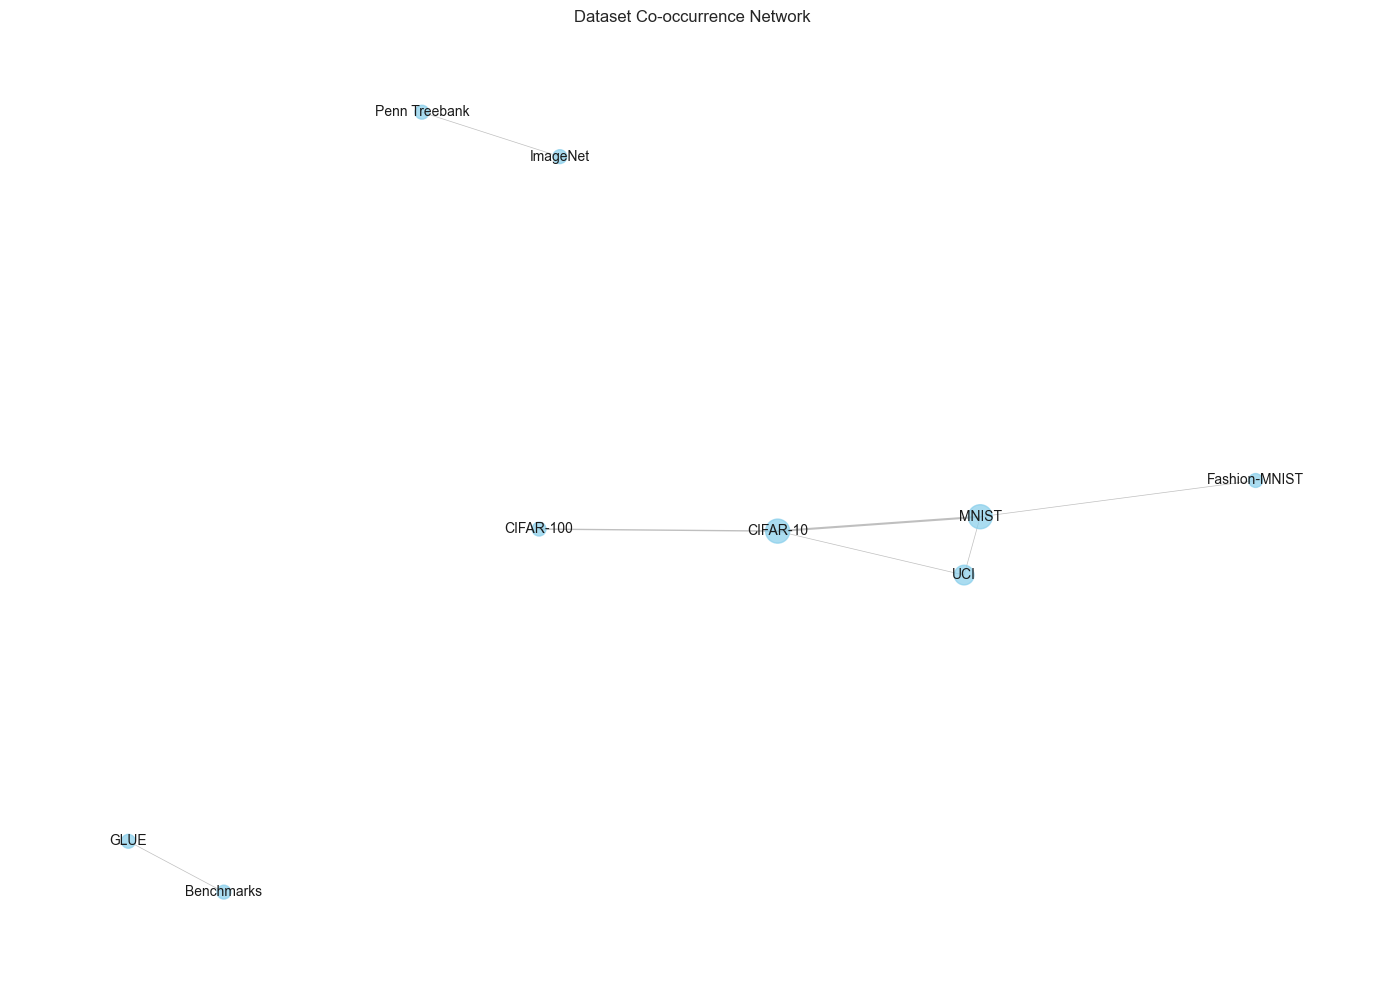


📊 Top Authors Using Popular Datasets:
                       author   dataset  paper_count
0               I. Goodfellow  ImageNet            2
1              Alexey Kurakin  ImageNet            2
2           Zoubin Ghahramani     MNIST            2
3                 Samy Bengio  ImageNet            2
4                      Y. Gal     MNIST            2
5          Kevin Leyton-Brown  CIFAR-10            1
6           Alireza Azadbakht  CIFAR-10            1
7   \n  Timoth\'ee Masquelier  CIFAR-10            1
8                    M. Kloft  CIFAR-10            1
9                 C. Thornton  CIFAR-10            1
10            Emmanuel Müller  CIFAR-10            1
11           Alexander Binder  CIFAR-10            1
12     Robert A. Vandermeulen  CIFAR-10            1
13      Shoaib Ahmed Siddiqui  CIFAR-10            1
14    Saeed Reza Kheradpisheh  CIFAR-10            1
15              A. Krizhevsky  CIFAR-10            1
16                 Lukas Ruff  CIFAR-10            1
17     

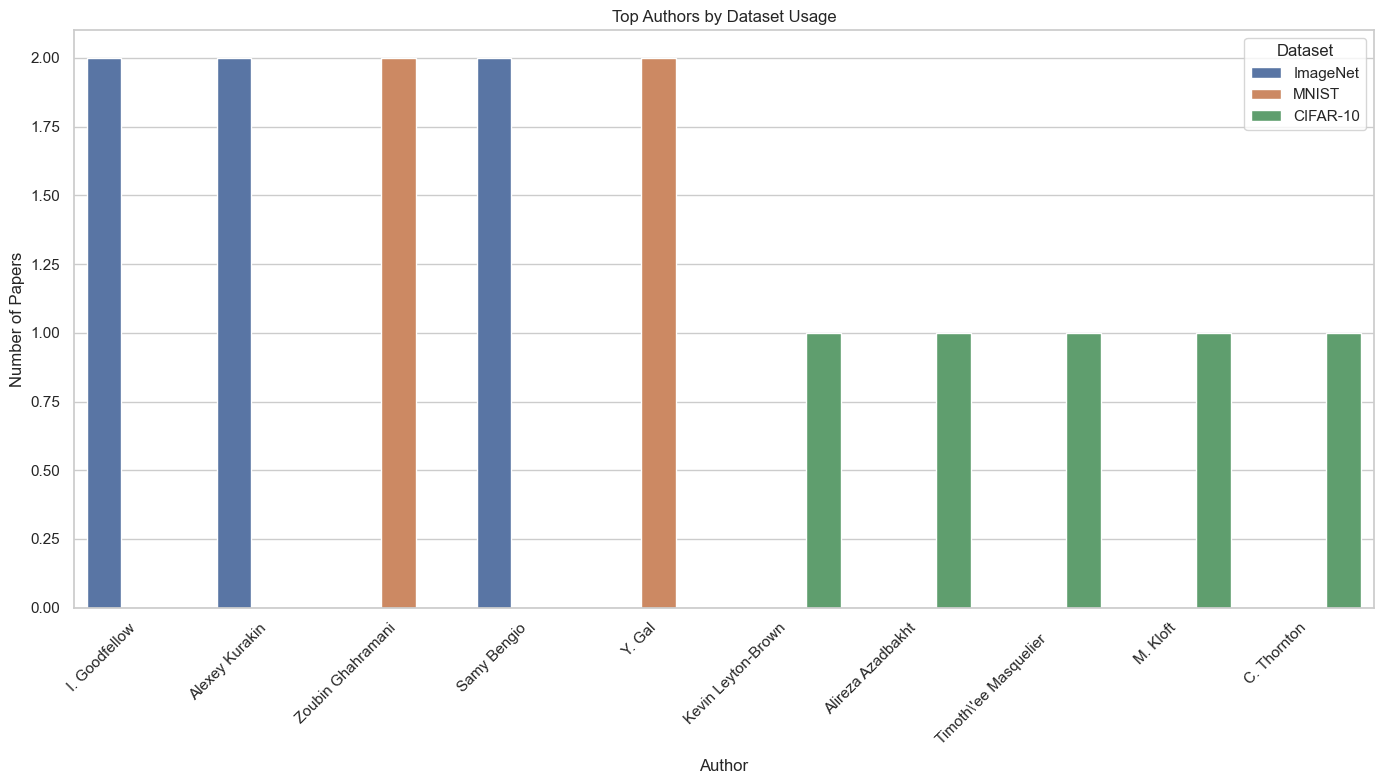

ClientError: [Statement.SyntaxError] The property existence syntax `... exists(variable.property)` is no longer supported. Please use `variable.property IS NOT NULL` instead. (line 3, column 43 (offset: 89))
"    WHERE d.name IN $top_datasets AND exists(p.venue) AND p.venue <> """
                                       ^

In [ ]:
def main():
    """Main execution function to run the entire pipeline."""
    print("🚀 Starting ML Research Dataset Knowledge Graph Analysis")

    # 1. Data Collection & Integration
    print("\n📥 Data Collection & Integration")

    # Load from processed files
    print("\n1.1. Loading cleaned Semantic Scholar data...")
    semanticscholar_papers = load_semantic_data(
        data_path="../data/processed/papers_semanticscholar_clean.json",
        max_papers=250
    )

    print("\n1.2. Loading cleaned ArXiv data...")
    arxiv_papers = load_arxiv_data(
        data_path="../data/processed/arxiv_ml_subset_10k.json",
        max_papers=250
    )

    # Normalize data
    print("\n1.3. Normalizing data schemas...")
    normalized_ss = normalize_paper_data(semanticscholar_papers, "semanticscholar")
    normalized_arxiv = normalize_paper_data(arxiv_papers, "arxiv")

    print(f"\nSemantic Scholar papers: {len(normalized_ss)}")
    print(f"ArXiv papers: {len(normalized_arxiv)}")

    # Combine & reconcile
    all_papers = normalized_ss + normalized_arxiv
    papers_df = pd.DataFrame(all_papers)

    print(f"\nTotal combined papers before reconciliation: {len(papers_df)}")
    print("Reconciling data sources to remove duplicates...")
    reconciled_df = reconcile_papers(papers_df)
    print(f"Total papers after reconciliation: {len(reconciled_df)}")

    # 2. Exploratory Data Analysis
    print("\n📊 Exploratory Data Analysis")
    analyze_dataset(reconciled_df)

    # 3. Dataset Extraction
    print("\n🔍 Dataset Extraction")
    extractions_df = extract_datasets(reconciled_df, confidence_threshold=0.7)

    # 4. Knowledge Graph Construction
    print("\n🔄 Knowledge Graph Construction")
    paper_count, dataset_count, rel_count = build_knowledge_graph(
        reconciled_df, extractions_df, graph
    )

    # 5. Advanced Queries & Analysis
    print("\n📈 Advanced Queries & Analysis")
    analysis_results = run_kg_analysis(graph)

    # 6. Evaluation Framework
    print("\n🧪 Evaluation Framework")
    evaluation_summary = evaluate_kg(reconciled_df, extractions_df, graph)

    # 7. Visualization & Reporting
    print("\n📋 Visualization & Reporting")
    dashboard_file = create_visualization_dashboard(
        reconciled_df, extractions_df, analysis_results
    )

    print("\n✅ Pipeline Complete!")
    print(f"📊 Results dashboard saved as: {dashboard_file}")

    return {
        "papers_df": reconciled_df,
        "extractions_df": extractions_df,
        "analysis_results": analysis_results,
        "evaluation": evaluation_summary,
        "dashboard": dashboard_file
    }

if __name__ == "__main__":
    results = main()